# Dataset Insights
This study looks at the spatio-temporal patterns in the _bus arrival time_ dataset to identify `where`, `when` & tentative reasons `why` scheduled deviations happen.

### Download & Preparation
> ℹ️ **NOTE:** This technical section is for report interactivity & reproducibility purpose only & can be skipped for regular readers.

In [1]:
%%capture

# Custom code
from source.data_loaders import *
from source.visualizations import *

# Notebook configurations
from IPython.display import display, Markdown
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"  # multi cell output

""" TIME EXPENSIVE - DO THIS JUST ONCE
# Locally download auxiliary data.
download_manitoba_roadnetwork()
download_manitoba_pois()

# Locally download necessary data.
download_transit_history(year="2023")
download_transit_history(year="2022")
"""

In [2]:
%%capture

# Sample & cleanup data.
df = load_transit_history(frac=0.10, year="2023", month="05")  # only 1 month for show.
df.drop([
    'Row ID',       # redundant since reindex
    'Route Name',   # redundant from 'Route Number'
    'Day Type',     # derivable from scheduled date
], axis=1, inplace=True)
df.dropna(inplace=True)

# Adjust types to save memory
df['Route Destination'] = df['Route Destination'].astype('category')
df['Stop Number'] = df['Stop Number'].astype('category')
df['Deviation'] = df['Deviation'] / 60  # [minutes] neg = late, pos = early
df['Scheduled Time'] = pd.to_datetime(df['Scheduled Time'], format='ISO8601')
df['Location'] = df['Location'].apply(lambda txt: wkt.loads(txt).wkb_hex).astype('category')

In [12]:
# show some of the data.
display(Markdown("<br>**Example Observactions**"))
df.sample(n=3)

display(Markdown("<br>**Column Statistics**"))
df.describe(include='all')

<br>**Example Observactions**

,Stop Number,Route Number,Route Destination,Scheduled Time,Deviation,Location
274401,60260,29,Logan via Sherbrook,2023-05-24 08:11:16,1.350000,0101000000B83E4AE5BD4958C034CF190FE5EC4840
291677,40118,92,Crossroads Station,2023-05-04 11:30:20,2.916667,010100000092D90974A24158C0965D8363F3F24840
297079,20542,15,Inkster Park via Inkster,2023-05-18 14:42:41,-2.133333,01010000002816450F654E58C0FAC952C666F34840


<br>**Column Statistics**

,Stop Number,Route Number,Route Destination,Scheduled Time,Deviation,Location
count,492429.0,492429,492429,492429,492429.000000,492429
unique,5124.0,105,182,NaN,NaN,5124
top,10629.0,11,Polo Park,NaN,NaN,010100000022E67E03D24858C0801AF54530F34840
freq,1319.0,25525,35064,NaN,NaN,1319
mean,NaN,NaN,NaN,2023-05-15 19:46:31.093446912,-2.431118,NaN
min,NaN,NaN,NaN,2023-05-01 00:17:53,-415.883333,NaN
25%,NaN,NaN,NaN,2023-05-08 09:15:19,-3.350000,NaN
50%,NaN,NaN,NaN,2023-05-15 16:43:32,-1.033333,NaN
75%,NaN,NaN,NaN,2023-05-24 07:28:46,0.366667,NaN
max,NaN,NaN,NaN,2023-05-31 23:59:33,385.000000,NaN


### Introduction

To get a representative view for this study, we took a subset of available data with the key characteristics & rationale described below.

|VALUE|CHARACTERISTIC|
|:----|:----|
|Jan/2022 - Oct/2023| **Time Frame**: Inclusive range of available data used in this analysis. We extracted 2 years of data to capture seasonality & anomalies. We focus on latest 2-years  to ensure relevance & consistency when comparing with external datasets. |
|10%| **Sample Rate**: Fraction of randomly chosen bus stop arrival time observations. We sub-sample to reduce volume of analysis & speedup results. We proportionally sample the same fraction each month to minimize bias due to ridership fluctuations.
|Winnipeg| **Region**: This & all auxiliary geo-spatial datasets used are strictly confined to the proper city limits. While inter-region routes can exists, data outside the city polygon are excluded as means to provide consistent analysis. This is especially true near edges as neighboring regions might have different sources & data characteristics. |
|10.3 M| **Observations**: number of raw datapoints in our sampled dataset. After pre-processing, each measures the time delay (in `minutes`) of bus scheduled vs arrival time for all stops at all times. No observation has missing column values. This is statistically large enough to make trusted conclusions & predictions. |


<br>
From this sample dataset, we can identify, define & quantify the following main entities in the transit network:

|VALUE|ENTITY|
|:----|:----|
|135| **Routes**: Distinct bus lines defined in the transit network. |
|428| **Directional Routes**: Distinguishing routes by direction of travel. Some routes can can have 1, 2 or multiple directions when they are a cycle, path or fork respectively. We use this as our basis of analysis in the design & implementation sections. |
|5,186| **Stops**: Unique bus stops (& terminals) in the network. A stop can service many routes. Stops are allocated to 1 side of the street & often correspond to 1 direction of travel. |


In [13]:
%%capture
""" PROOF OF SOME TABLE VALUES
print(f"{'observations:':<20}{df.shape[0]}")
print(f"{'routes:':<20}{df['Route Number'].drop_duplicates().shape[0]}")
print(f"{'dir routes:':<20}{df[['Route Number', 'Route Destination']].drop_duplicates().shape[0]}")
print(f"{'stops:':<20}{df['Stop Number'].drop_duplicates().shape[0]}")
"""


<img src="../images/routes.png" width="100%">
A map of these transit network entities is visualized above. 
It color codes individual bus stops by route & overlays roads within the city boundaries for context. Due to Winnipeg's geography, the transit network exhibits 2 distinct characteristics: 

* **Star Topology**: Most routes emanate in all directions from a central down town core. This can be a congestion factor as traffic volumes concentrate in areas increasing likelihood of accidents & delays

* **Rivers**: Among others, the Red-River acts as a natural east/west divider for the city as there are limited bridges routes can take  acting as potential bottlenecks.


## Spatial Analysis
This section looks at the location of bus stops that chronically deviate from scheduled times. 

<img src="../images/timeline_deviation.png" width="100%">

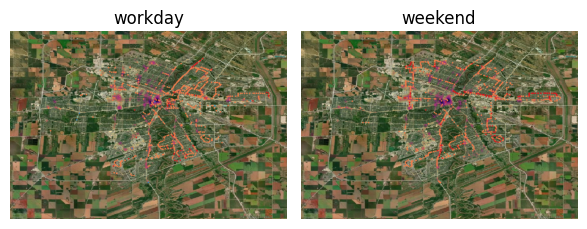

In [4]:
plot_hot_zone_image_row("weekly", items=["workday", "weekend"])

----
**[<<PREV](part1_insights.ipynb)** |
**[NEXT>>](part2_design.ipynb)**